# Atividade Prática 2 - Parte 2

## 2.

A aproximação função $seno(x)$ no intervalo $[-\frac{\pi}{2}, \frac{3\pi}{2}]$
realizada por meio do modelo de Sugeno usa três regras <em>fuzzy</em> e portanto
três antecedentes e consequentes. Os consequentes são lineares e os
antecedentes, funções de pertinência triangulares, são lineares por partes. O
desenvolvimento analítico a seguir se baseia na escolha de consequentes e
antecedentes ilustrada na Figura 1. Observa-se que é possível
dividir a região de inferência entre $[\frac{-\pi}{2}, \frac{\pi}{2}]$ e
$[\frac{\pi}{2}, \frac{3\pi}{2}]$ de forma que as funções de pertinência sejam
lineares.

In [1]:
# inserir figura 1 aqui

### Consequentes

Os consequentes foram definidos por inspeção da Figura 1 pelas seguintes retas:

$y_1(x) = \frac{2}{\pi}x + 1$ <br>
$y_2(x) = -\frac{2}{\pi}x + 1$ <br>
$y_3(x) = \frac{2}{\pi}x - 3$ <br>

### Antecedentes

As retas antecedentes das regiões 1 e 2 são definidas por inspeção da Figura 1.

Região 1: $x \in [-\frac{\pi}{2}, \frac{\pi}{2}]$

$a_1(x) = -\frac{1}{\pi}x + \frac{1}{2}$ <br>
$a_2(x) = \frac{1}{\pi}x + \frac{1}{2}$ <br>

Região 2: $x \in [\frac{\pi}{2}, \frac{3\pi}{2}]$

$a_3(x) = -\frac{1}{\pi}x + \frac{1}{2} + \pi$ <br>
$a_4(x) = \frac{1}{\pi}x + \frac{1}{2} + \pi$ <br>


### Inferência

A inferência analítica é dada por partes:

$ 
    \hat{y}(x) =
    \begin{cases}
    \frac{a_{1}(x)y_{1}(x) + a_{2}(x)y_{2}(x)}{a_{1}(x)+a_{2}(x)} & x \in [-\frac{\pi}{2}, \frac{\pi}{2}]\\
    \frac{a_{3}(x)y_{2}(x) + a_{4}(x)y_{3}(x)}{a_{3}(x)+a_{4}(x)} & x \in [\frac{\pi}{2}, \frac{3\pi}{2}] \\
   \end{cases}
$

## 3.

In [2]:
import sys
import numpy as np
from numpy import polyfit
from matplotlib import pyplot as plt

plt.style.use("ggplot")

Define-se classes para funções lineares com possibilidade de computação a partir de 2 pontos:

In [3]:
class Linear:

    def __init__(self, b=None, m=None, compute=False, data=None):

        self.b = b
        self.m = m

        if compute:
            self.m, self.b = np.polyfit(data[0], data[1], 1)

    def infer(self, x):
        return x*self.m + self.b

    def plot(self, b=0, e=1, show=False, c="red", legend=None):
        x = np.linspace(b, e, 500)
        y = [self.infer(_x) for _x in x]

        if legend is not None:
            plt.plot(x, y, c=c, label=legend)

        plt.plot(x, y, c=c)

        if show:
            plt.show()

Define-se funções de pertinência triangular e gaussiana:

In [4]:
class Gaussmf(Linear):

    def __init__(self, c, sigma):
        self.c = c
        self.sigma = sigma

    def infer(self, x):
        return np.exp(-np.power(x - self.c, 2.) / (2 * np.power(self.sigma, 2.)))

class Trimf(Linear):

    def __init__(self, a, b, c):
        self.a = a
        self.b = b
        self.c = c

    def infer(self, x):

        if x <= self.a:
            return 0
        if x <= self.b:
            return (x-self.a)/(self.b-self.a)
        if x <= self.c:
            return (self.c-x)/(self.c-self.b)

        return 0

Define-se classe para inferência de Sungeno:

In [5]:
class Sugeno():

    def __init__(self, antecedents, consequents):
        assert(len(consequents) == len(antecedents))
        self.consequents = consequents
        self.antecedents = antecedents

    def infer(self, x):
        weights = [ant.infer(x) for ant in self.antecedents]
        consequent_values = [con.infer(x) for con in self.consequents]

        output = 0
        for (w, cm) in zip(weights, consequent_values):
            output += w*cm

        normal_output = output/sum(weights)

        return normal_output

    def inferbycurve(self):
        weights = self.antecedents
        consequent_values = self.consequents

        output = 0
        for (w, cm) in zip(weights, consequent_values):
            output += w*cm

        normal_output = output/sum(weights)

        return normal_output

Define-se função para criação de consequentes de ordem 1:

In [6]:
def create_con(px=None, py=None, n_points=None):

    if px is not None: # caso onde px eh passado

        pass

    else:

        px = np.linspace(0, 2*p, n_points)
        py = [np.sin(x) for x in px]

    n_consequents = len(px) - 1
    con = []

    for i in range(n_consequents):
        l = Linear(compute=True, data=(px[i:i+2], py[i:i+2])) #consequentes de ordem 1
        con.append(l)

    return con, n_consequents

Define-se função para criação de antecedentes triangulares ou gaussianos:

In [7]:
def create_ant(px, n_cons, gs=1.2, tri=True):

    centers = np.linspace(px[0], px[-1], n_consequents)

    s = (px[1] - px[0])*2

    if tri:

       ant = [Trimf(c-s, c, c+s) for c in centers]

    else:
        ant = [Gaussmf(c, gs) for c in centers]

    return ant, centers, s

Define-se função para visualização de espaço de inferência:

In [8]:
def see_inference(px, con, ant, centers, s, mse):

# Plot de consequentes

    for cc, cons in enumerate(con[:-1]):
        cons.plot(px[cc], px[cc+1])

    con[-1].plot(px[n_consequents - 1], px[n_consequents], legend="Consequentes")

# plotta antecedentes
# antecentedes iniciais e finais sao clippados para o dominio de interesse

    first_c = centers[0]
    last_c = centers[len(centers)-1]

    ant[0].plot(first_c, first_c + s, c="blue")

    ant[len(ant) - 1].plot(last_c - s, last_c, c="blue", legend="Antecedentes")

    for (a, c) in zip(ant[1:n_consequents-1], centers[1:n_consequents-1]):
        a.plot(c - s, c + s, c="blue")
    plt.plot(x, y, c="black", label="Função aproximada")
    plt.plot(x, y_hat,"--", c="black", label="Aproximação")

    plt.plot([], label = f"Erro: {mse:.3f}", c="white")

    plt.legend()
    plt.show()

In [9]:
# Carrega valor de pi

p = 3.14

a) Experimento 1:

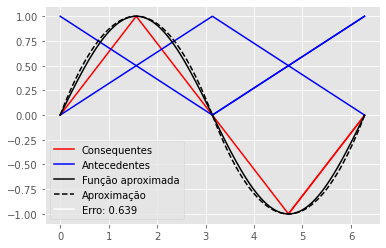

In [10]:
# Pontos sao escolhidos por inspecao da funcao seno

px = [0, p/2, 3*p/2, 2*p]
py = [np.sin(x) for x in px]

# Consequentes e antecedentes triangulares sao criados

con, n_consequents = create_con(px, py)

ant, centers, s = create_ant(px, n_consequents, tri=True)

# Inferencia e erro

sugeno = Sugeno(ant, con)

x = np.linspace(px[0], px[n_consequents], 500)
y = [np.sin(_x) for _x in x]
y_hat = np.array([sugeno.infer(_x) for _x in x])

mse = np.sum((y - y_hat) ** 2)

# visualizacao

see_inference(px, con, ant, centers, s, mse)

b) Experimento 2:

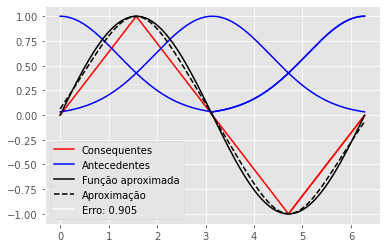

In [11]:
# Redefinicao de antecedentes

ant, centers, s = create_ant(px, n_consequents, 1.2, tri=False)

# Inferencia e erro

sugeno = Sugeno(ant, con)
y_hat = np.array([sugeno.infer(_x) for _x in x])

mse = np.sum((y - y_hat) ** 2)

# visualizacao

see_inference(px, con, ant, centers, s, mse)

c) Experimento 3:

O número de pontos é aumentado e o processo de inferência é repetido com ambos antecedentes. <br>
Nota-se que para pequenos números de pontos sua posição é bem relevante para o erro, tornando o processo de escolha automática uma má ideia. Se os pontos forem escolhidos por inspeção, no entanto (como nas letras (a) e (b)) o erro é bem minimizado. A medida que o número de pontos aumenta a diferença a relevância de sua posição diminui tornando o processo de escolha automática aceitável. Conclui-se então que, para o processo de escolha automática de pontos, o desempenho aumenta com o número de pontos. Isso também pode ser dito para a escolha analítica. <br>
O código é funcional para n_pontos < 500.

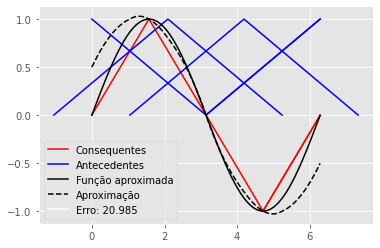

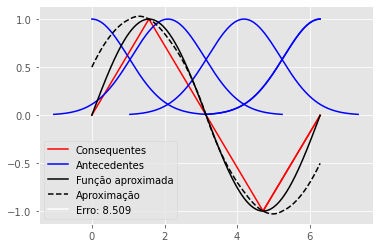

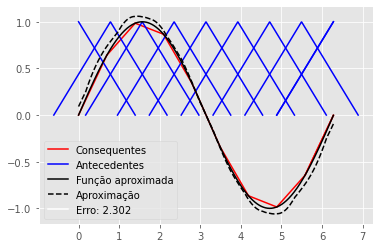

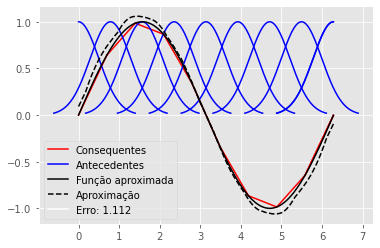

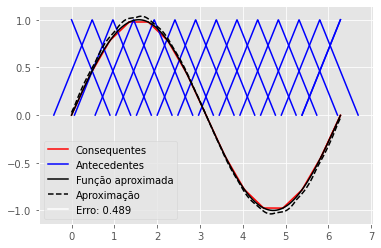

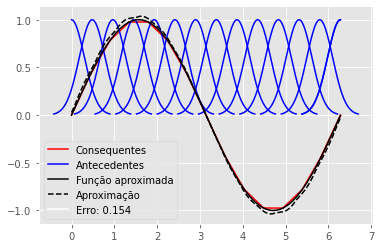

In [12]:
# para 5 pontos

n_points = 5

px = np.linspace(0, 2*p, n_points)
py = [np.sin(x) for x in px]

con, n_consequents = create_con(px, py) # cria consequentes
ant, centers, s = create_ant(px, n_consequents, tri=True)
antg, centersg, sg = create_ant(px, n_consequents, gs=1, tri=False)

sugeno = Sugeno(ant, con)
sugenog = Sugeno(antg, con)

x = np.linspace(px[0], px[n_consequents], 500)
y = [np.sin(_x) for _x in x]
y_hat = np.array([sugeno.infer(_x) for _x in x])
y_hatg = np.array([sugenog.infer(_x) for _x in x])

mse = np.sum((y - y_hat) ** 2)
mseg = np.sum((y - y_hatg) ** 2)

see_inference(px, con, ant, centers, s, mse)
see_inference(px, con, antg, centersg, sg, mseg)

# para 10 pontos 

n_points = 10

px = np.linspace(0, 2*p, n_points)
py = [np.sin(x) for x in px]

con, n_consequents = create_con(px, py) # cria consequentes
ant, centers, s = create_ant(px, n_consequents, tri=True)
antg, centersg, sg = create_ant(px, n_consequents, gs=.5, tri=False)

sugeno = Sugeno(ant, con)
sugenog = Sugeno(antg, con)

x = np.linspace(px[0], px[n_consequents], 500)
y = [np.sin(_x) for _x in x]
y_hat = np.array([sugeno.infer(_x) for _x in x])
y_hatg = np.array([sugenog.infer(_x) for _x in x])

mse = np.sum((y - y_hat) ** 2)
mseg = np.sum((y - y_hatg) ** 2)

see_inference(px, con, ant, centers, s, mse)
see_inference(px, con, antg, centersg, sg, mseg)

# para 15 pontos

n_points = 15

px = np.linspace(0, 2*p, n_points)
py = [np.sin(x) for x in px]

con, n_consequents = create_con(px, py) # cria consequentes
ant, centers, s = create_ant(px, n_consequents, tri=True)
antg, centersg, sg = create_ant(px, n_consequents, gs=.3, tri=False)

sugeno = Sugeno(ant, con)
sugenog = Sugeno(antg, con)

x = np.linspace(px[0], px[n_consequents], 500)
y = [np.sin(_x) for _x in x]
y_hat = np.array([sugeno.infer(_x) for _x in x])
y_hatg = np.array([sugenog.infer(_x) for _x in x])

mse = np.sum((y - y_hat) ** 2)
mseg = np.sum((y - y_hatg) ** 2)

see_inference(px, con, ant, centers, s, mse)
see_inference(px, con, antg, centersg, sg, mseg)

## 4.

Será utilizada uma distribuição gaussiana para a modelagem os antecedentes.

In [13]:
def gaussmf(x, c, sigma):
    mu = np.exp(-1 / 2 * ((x - c) / sigma) ** 2)
    return mu

Primeiro as váriaveis de entrada foram tratadas como uma variável apenas

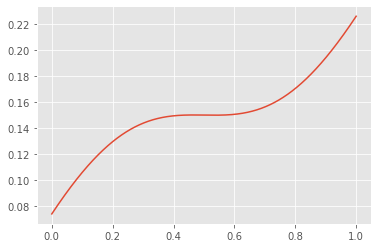

In [14]:
# x: food / service, y : tip
x = np.linspace(start = 0, stop = 1, num = 1000)

#antecedentes
lim = 0.35      #ajuste manual
ruim = gaussmf(x = x, c = 0, sigma = lim)
bom = gaussmf(x = x, c = 0.5, sigma = lim)
excelente = gaussmf(x = x, c = 1, sigma = lim)

#consequentes
p1 = (0.15 - 0.05) / 0.25
q1 = 0.05
y1 = p1 * x + q1

p2 = 0
q2 = 0.15
y2 = p2 * x + q2

p3 = (0.25 - 0.15) / 0.25
q3 = - 0.15
y3 = p3 * x + q3

#sugeno
ant = list([ruim, bom, excelente])
con = list([y1, y2, y3])

model = Sugeno(consequents = con, antecedents = ant)
yhat = model.inferbycurve()

plt.plot(x, yhat)

Agora, tratou-se as variáveis realmente como independentes. Para isso, os antecedentes das regras devem ser tratados com uma operação t-norm.

In [15]:
def tnorm(U, V):
    #min
    mesh = np.array(np.meshgrid(U, V))
    combinations = mesh.T.reshape(-1, 2)
    return np.amin(combinations, axis = 1)

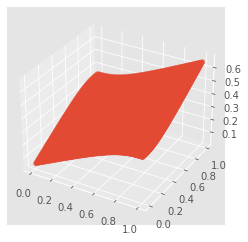

In [16]:
# x1, x2: food / service, y : tip
x1 = np.linspace(start = 0, stop = 1, num = 100)
x2 = np.linspace(start = 0, stop = 1, num = 100)

#antecedentes
#x1
lim = 0.35      #ajuste manual
ma = gaussmf(x = x1, c = 0, sigma = lim)
boa = gaussmf(x = x1, c = 0.5, sigma = lim)
deliciosa = gaussmf(x = x1, c = 1, sigma = lim)

#x2
lim = 0.35      #ajuste manual
ruim = gaussmf(x = x2, c = 0, sigma = lim)
bom = gaussmf(x = x2, c = 0.5, sigma = lim)
excelente = gaussmf(x = x2, c = 1, sigma = lim)

#consequentes
grid = np.array([(orde, absc) for orde in x1 for absc in x2])

p1 = (0.15 - 0.05) / 0.25
q1 = 0.05
y1 = p1 * (grid[:, 0] + grid[:, 1]) + q1

p2 = 0
q2 = 0.15
y2 = p2 * grid[:, 1] + q2

p3 = (0.25 - 0.15) / 0.25
q3 = - 0.15
y3 = p3 * (grid[:, 0] + grid[:, 1]) + q3


#sugeno
ant = list([tnorm(ruim, ma), 
            tnorm(bom, np.zeros(shape = deliciosa.shape)), 
            tnorm(excelente, deliciosa)])
con = list([y1, y2, y3])

model = Sugeno(consequents = con, antecedents = ant)
yhat = model.inferbycurve()

#plot
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(grid[:, 0], grid[:, 1], yhat)